In [25]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [8]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [9]:
# 7000 data with 300 features
print(x_train.shape)
print(x_test.shape)

(7000, 300)
(3000, 300)


In [10]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [11]:
def cross_validation(x_train, y_train, k=5):
    n = x_train.shape[0]
    index = np.arange(n)
    np.random.shuffle(index)
    size = n // k
    folds = []
    start = 0
        
    for i in range(n % k):
        val = index[start : start + size + 1]
        train = np.hstack((index[:start], index[start + size + 1:]))
        start += size + 1
        folds.append([train, val])
    for i in range(n % k, k):
        val = index[start : start + size]
        train = np.hstack((index[:start], index[start + size:]))
        start += size 
        folds.append([train, val])
        
    return folds

In [12]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [13]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kff = cross_validation(X,X)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])
# for i, (train_index, val_index) in enumerate(kff):
    # print("Split: %s, Training index: %s, Validation index: %s" % (i+1, sorted(train_index), sorted(val_index)))

Split: 1, Training index: [ 1  2  3  4  5  6  7  8  9 10 13 14 15 16 18 19], Validation index: [ 0 11 12 17]
Split: 2, Training index: [ 0  1  2  3  7  8  9 10 11 12 13 15 16 17 18 19], Validation index: [ 4  5  6 14]
Split: 3, Training index: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 16 17], Validation index: [ 8 15 18 19]
Split: 4, Training index: [ 0  1  2  3  4  5  6  8 11 12 13 14 15 17 18 19], Validation index: [ 7  9 10 16]
Split: 5, Training index: [ 0  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19], Validation index: [ 1  2  3 13]


In [14]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [15]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [16]:
def gridsearch(c_cand, gamma_cand, K, x_data, y_data):
    best_c, best_gamma = 0, 0 
    best_acc = 0
    acc = []
    kfolds = cross_validation(x_data, y_data, K)
    for c in c_cand:
        tmp = []
        for g in gamma_cand:
            tmp_acc = 0
            for i, (train_in, val_in) in enumerate(kfolds):
                clf = SVC(C=c, kernel='rbf', gamma=g)
                clf.fit(x_data[train_in], y_data[train_in]) 
                y_pred = clf.predict(x_data[val_in])
                tmp_acc += np.sum(y_pred == y_data[val_in])
            tmp_acc = round(tmp_acc / x_data.shape[0], 5)
            tmp.append(tmp_acc)
            if tmp_acc >= best_acc:
                best_acc = tmp_acc
                best_c, best_gamma = c, g
        acc.append(tmp)
    print(f"C= {best_c} gamma= {best_gamma} with average accuracy: {best_acc}")
    return acc, (best_c, best_gamma)

In [17]:
c_cand = [ 10, 100, 1000, 1e4, 1e5, 1e6, 1e7]
# c_cand = [ 1e-1, 1, 10, 100, 1000, 1e4, 1e5]
gamma_cand = [1e-9,1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
gridsearch_acc, best_parameters = gridsearch(c_cand, gamma_cand, 5, x_train, y_train)


C= 10000000.0 gamma= 0.0001 with average accuracy: 0.99314


In [96]:
c_cand = [ 1e8, 1e9, 1e10, 1e11, 1e12, 1e13]
# c_cand = [ 1e-1, 1, 10, 100, 1000, 1e4, 1e5]
gamma_cand = [ 1e-5, 1e-4, 1e-3]
gridsearch_acc5, best_parameters5 = gridsearch(c_cand, gamma_cand, 5, x_train, y_train)

C= 100000000.0 gamma= 0.0001 with average accuracy: 0.99343


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [20]:
import matplotlib.pyplot as plt
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None, **kwargs):
    # if not ax:
    #     ax = plt.gca()
    im = ax.imshow(data, **kwargs)
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    plt.setp(
        ax.get_yticklabels(), rotation=90,
        va='bottom', ha='center', rotation_mode='anchor')
    ax.set_xlabel('Gamma Parameter')
    ax.set_ylabel('C Parameter')
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            text = ax.text(j, i, round(data[i, j],3),
                        ha="center", va="center", color="black")
    # ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    return im


# def annotate_heatmap(im, valfmt, threshold=None):
    data = im.get_array()
    # if threshold is not None:
    #     threshold = im.norm(threshold)
    # else:
    #     threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    # textcolors = ['black', 'white']
    textcolors = ['black', 'black']
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # kw.update(color=textcolors[int(im.norm(data[i, j])>threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

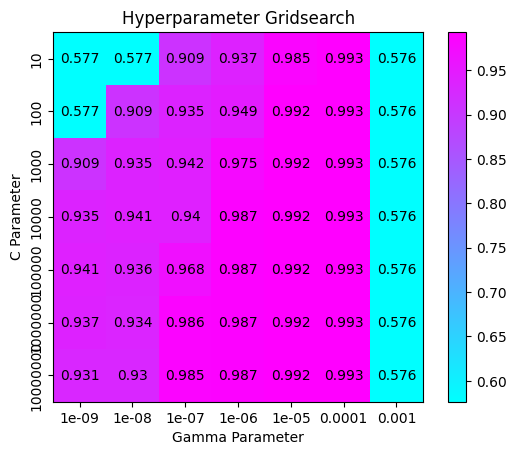

In [21]:
fig, ax = plt.subplots()
for i  in range(len(c_cand)):
    if c_cand[i] > 1:
        c_cand[i] = int(c_cand[i])
im = heatmap(np.asarray(gridsearch_acc), c_cand, gamma_cand, ax=ax, cmap='cool')
plt.title('Hyperparameter Gridsearch')
# fig.tight_layout()
# plt.savefig('gridsearch_svc.png', dpi=300, transparent=True)
# plt.clf()
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [22]:
best_model = SVC(C=best_parameters[0], kernel='rbf', gamma=best_parameters[1])
best_model.fit(x_train, y_train) 
# y_pred = best_model.predict(x_train)
# print("Accuracy score: ", accuracy_score(y_pred, y_train))
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined